# Preliminaries

## Dataset

In this set of exercises we will use the same dataset as from [week 3](week_3.ipynb). 


As before, we provide the data already curated in the following two files:

`RNA_expression_curated.csv`: [148 cell lines , 238 genes]

`drug_response_curated.csv`: [148 cell lines , YM155 drug]

The curated data can be read as `pandas` `DataFrame` in the following way:

In [1]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

The goal of the exercises is to train support vector machine (SVM) and random forests classifiers on this dataset and explore and learn about their hyperparameters. 

## Tools

The `scikit-learn` library provides the required tools for support vector machines, as well as for random forest algorithms.

In [2]:
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
#from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import classification_report

Before proceeding, look up the documentation of the imported functions and read about their basic functionality. Below, we list some important parameters of SVMs and random forests that can be tuned during training.

#### Support Vector Machines (SVM)

`C`: error term.

`kernel`: similarity function ('linear', 'poly', 'sigmoid' or 'rbf')

`gamma`: kernel coef. for 'rbf', 'poly' and 'sigmoid' kernels. It can be thought of as the ‘spread’ of the kernel and therefore the decision region.

`degree`: degree for the 'poly' kernel.

`coef0`: independt term in the 'poly' and 'sigmoid' kernels


#### Random Forests

`n_estimators`: number of trees in our random forest.

`max_depth`: maximum number of levels in each decision tree

`max_features`: maximum number of features to consider per split in an individual tree.

`min_sample_leaf`: minimum number of data points per leaf node

`min_samples_split`: minimum number of data points placed in a node before the node is split

`oob_score`: the out-of-bag (OOB) error is the average error for each observation calculated using predictions from the trees that do not contain that observation in their respective bootstrap sample. Set this parameter to true.

`bootstrap`: method for sampling data points (with or without replacement). Set this parameter to true.

`criterion`: function used to measure the quality of the split (e.g. 'entropy' or 'gini')

# Exercises

## Support vector machines

The  `make_blobs` and `make_circles` functions can be used to generate linearly and not linearly separable toy datasets. 

In [3]:
# data generation: linearly separable
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

The following code illustrates how to train a linear SVM classifier and plot the data points, the separating hyperplane, the support vectors and the margins that pass through them (considering the training data)

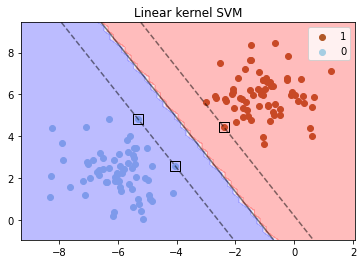

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# build the model
model = svm.SVC(kernel='linear', random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('Linear kernel SVM')
plt.show()

Train a radial basis function (RBF) SVM classifier with `gamma=0.5` and plot the results in the same way.

In [5]:
# data generation: not linearly separable
X, Y = make_circles(n_samples=200, noise=0.05, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

<p><font color='#770a0a'>When should a RBF kernel be used over a linear kernel? Motivate your answer.</font></p>

<p><font color='#770a0a'>Do we need to normalize the data before using a kernel function? Motivate your answer.
</font></p>

## Predicting drug response on cell lines from gene expression data with SVMs

Explore the hyper-parameter space of an SVM classifier with cross-validation for the Genomics of Drug Sensitivity in Cancer (GDSC) dataset. The`GridSearchCV` function can be used to specify a grid of parameter values with the `param_grid` parameter.

Calculate the precision of your predictions, and compare your calculations with the results of `classification_report`, which displays many classification metrics.


## Random forests

Follow the same steps as for SVM. Compare the two algorithms and report which one has better performance.

In [6]:
from scipy import stats

#___Transform the numerical data to categorical data to perform classification___

# Compute the z score across all cell lines in the dataset for each drug
z_score = stats.zscore(drug_response.squeeze())

# Classify the cells as sensitive or resistant based on the IC50 metric
# Cells with z-score < 0 are considered sensitive and cells with z-score > 0 are considered resistant
z_score[z_score > 0] = 0
z_score[z_score < 0] = 1

# Make the training and test sets with X the gene expression and Y the z-score
X_train, X_test, y_train, y_test = train_test_split(gene_expression, z_score)

In [7]:
#___Explore the hyper-parameter space of an Random Forests classifier with cross-validation___

# Define the model
estimator = RandomForestClassifier(bootstrap = True, oob_score = True, verbose = 2)

# Define the parameters for the grid search
param_grid = {'n_estimators': np.linspace(200, 400, 5).astype(int),
              'criterion': ['gini', 'entropy'],
              'max_depth': np.linspace(5, 10, 5).astype(int),
              'max_features': np.linspace(80, 150, 5).astype(int),
              'min_samples_leaf': np.linspace(4, 8, 5).astype(int),
              'min_samples_split': np.linspace(2, 6, 5).astype(int)}

# Estimator values between linspace were chosen by running the model a couple of times, and finetuning these parameters. 
# First run: best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 
                            #'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
# Second run: best parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 50,
                            #'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}
#Third run: best parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 100,
                  #'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 250}

# Perform the grid search of the parameters with the default 5-fold cross validation
grid_search = GridSearchCV(estimator = estimator,
                           param_grid = param_grid,
                           scoring = 'precision', # To compare with precision of SVM
                           n_jobs = -1, # To use all processors
                           verbose = 2) # To display the computation time and score for each fold

# Fit the model
grid_search.fit(X_train, y_train)

# Show the best parameters of the model
print('best parameters: {}'.format(grid_search.best_params_))

# Use these parameters to make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 6250 candidates, totalling 31250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
b

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


In [8]:
#___Calculate the precision of the random forests, and compare with the performance of the SVM___

# Make a classification report
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n         0.0       0.69      0.60      0.64        15\n         1.0       0.75      0.82      0.78        22\n\n    accuracy                           0.73        37\n   macro avg       0.72      0.71      0.71        37\nweighted avg       0.73      0.73      0.73        37\n'

***Question***: Compare the SVM algorithm with the random forests, and report which one has better performance. 

***Answer***: 

The random forests classifiers allows to perform feature selection. Evaluate the importance of features extracting the top 50 informative features. A bar plot (`plt.bar()`) can be a useful tool to visualize this. 

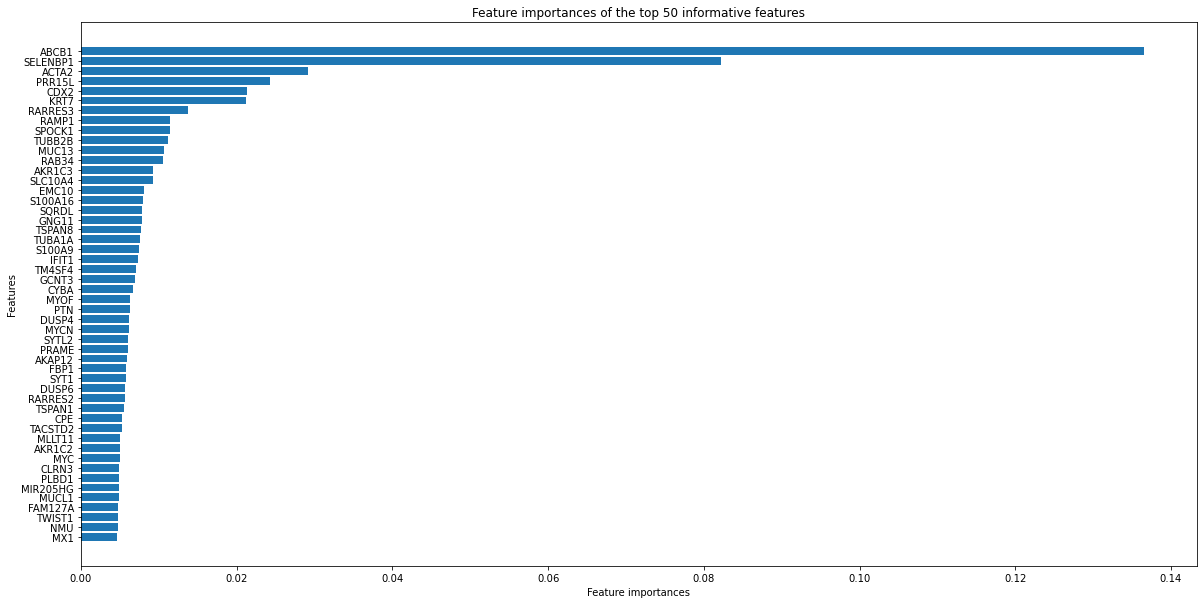

In [10]:
#___ Visualise the top 50 informative features___

# Get the feature importances and their labels from the grid search
feature_importances = grid_search.best_estimator_.feature_importances_
labels = gene_expression.columns
labelled_importances = pd.Series(feature_importances, labels)

# Rearange the importances from largest to smallest
rearanged_importances = labelled_importances.sort_values(ascending = False)

# Get the top 50 informative features
top50 = rearanged_importances[0:50]

# Rearange the top 50 feature importances from smallest to largest
rearanged_top50 = top50.sort_values(ascending = True)

plt.figure(figsize=(20,10))
plt.barh(rearanged_top50.index, rearanged_top50)
plt.title('Feature importances of the top 50 informative features')
plt.xlabel('Feature importances')
plt.ylabel('Features')
plt.show()

## Biomedical applications

Driven by technological advances, there has recently been a dramatic increase in availability of biomedical data. Machine learning approaches are well suited to take advantage of this data and have been widely applied to many areas of biology. 

Example of these applications are genome annotation, biomarker identification, systems biology, genome data analysis, protein  function  prediction, protein  structure prediction, protein localization prediction, identification of protein interactions and drug discovery.

SVM and RF methods are among the most popular machine learning methods applied in bioinformatics or computational biology.

Perform a literature search and find a biomedical study in which SVM or RF is applied to obtain certain insights. <p><font color='#770a0a'>Explain the motivation behind using that specific algorithm in the study.
</font></p>